# Map Visualizations


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely import Point
from branca.colormap import LinearColormap
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

In [2]:
census_bbox = gpd.read_file('../get_population_data/census_final_data.json',driver= 'GeoJSON')
park_catchment_areas = gpd.read_file('../get_isodistances/isodistances_entrance_park_coordinates.json',driver= 'GeoJSON')
park_centroid_catchment_areas = gpd.read_file('../get_isodistances/isodistances_centroid.json',driver= 'GeoJSON')
park_areas = gpd.read_file('../get_park_data/data.json',driver= 'GeoJSON')
entrance_acc_score = pd.read_json('../accessibility_score/entrance_score.json', orient='index')
centroid_acc_score = pd.read_json('../accessibility_score/centroid_score.json', orient='index')
centroid_intersection = gpd.read_file('../get_isodistances/centroid_intersection.json',driver= 'GeoJSON')
entrance_intersection = gpd.read_file('../get_isodistances/entrance_intersection.json',driver= 'GeoJSON')

## Folium Ansätze

In [3]:
def map_one_park_polygons(park_df,park_name,census):
    park = park_df[park_df.name == park_name]
    map = folium.Map(location=[53.41535, 9.90225], tiles="CartoDB Positron", zoom_start=11, control_scale = True)
    for _, r in census.iterrows():
        sim_geo_ = gpd.GeoSeries(r["geometry"])
        geo_j_ = sim_geo_.to_json()
        geo_j_ = folium.GeoJson(data=geo_j_, style_function=lambda x: {"fillColor": "orange"})
        folium.Popup(r["row_number"]).add_to(geo_j_)
        geo_j_.add_to(map)
    for _, r in park.iterrows():
        sim_geo = gpd.GeoSeries(r["geometry"])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "green"})
        if 'name' in park.columns:
            folium.Popup(r["name"]).add_to(geo_j)
        geo_j.add_to(map)
    
    return map

In [4]:
def map_multiple_polygons(park,census):
    map = folium.Map(location=[53.41535, 9.90225], tiles="CartoDB Positron", zoom_start=11, control_scale = True)
    for _, r in census.iterrows():
        sim_geo_ = gpd.GeoSeries(r["geometry"])
        geo_j_ = sim_geo_.to_json()
        geo_j_ = folium.GeoJson(data=geo_j_, style_function=lambda x: {"fillColor": "orange"})
        if 'row_number' in census.columns:
            folium.Popup(r["row_number"]).add_to(geo_j_)
        geo_j_.add_to(map)
    for _, r in park.iterrows():
        sim_geo = gpd.GeoSeries(r["geometry"])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "green"})
        if 'name' in park.columns:
            folium.Popup(r["name"]).add_to(geo_j)
        geo_j.add_to(map)
    
    return map

In [5]:
def map_catchment_heatmap(park, catchment_area, park_name, census, sociodemographics, buffer):
    map = folium.Map(location=[53.554831, 10.000305], tiles="CartoDB Positron", zoom_start=11, control_scale = False)
    
    # buffering arround park catchment area to get nearest census blocks
    catchment_park_df = catchment_area[catchment_area["name"] == park_name].reset_index()
    park_3395 = catchment_park_df.to_crs(epsg=3395)
    bbox_park = park_3395.buffer(buffer,cap_style = 1)

    # convert buffered polygon back to 4326 crs
    envgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_park))
    bbox_4326 = gpd.GeoDataFrame(envgdf, crs='EPSG:3395')
    bbox_4326 = bbox_4326.to_crs(epsg=4326)
    bbox_4326["name"] = catchment_park_df["name"]
    bbox_4326

    # find subset of census blocks intersecting with buffered catchment area
    intersecting_blocks = gpd.sjoin(census,bbox_4326,how = "inner", predicate="intersects")

    # convert census df to GeoJSON
    census_gjson = intersecting_blocks.to_json()

    # create choropleth and add to map
    folium.Choropleth(
        geo_data = census_gjson,
        name="choropleth",
        data=intersecting_blocks,
        columns =["row_number", sociodemographics],
        key_on = "feature.properties.row_number",
        fill_color="YlOrBr",
        fill_opacity=0.8,
        line_opacity=0.6,
        legend_name="Average Age"
    ).add_to(map)
    
    sozio = folium.features.GeoJson(
    intersecting_blocks, 
    control=False,
    tooltip=folium.features.GeoJsonTooltip(
        fields=[sociodemographics],
        aliases=[sociodemographics]
        ))
    
    # adding catchment area,reduced by park area to map
    park_area = park[park["name"] == park_name].reset_index()
    difference = catchment_park_df["geometry"].difference(park_area["geometry"])
    difference = folium.GeoJson(data=difference, style_function=lambda x: {"fillColor": "green","fillOpacity": 0.9, "color": "green", "stroke":True,"weight":0.5})
    
    difference.add_to(map)
    
    #map.add_child(sozio)
    map.keep_in_front(difference)
    return map

In [6]:
def map_accessibility_scores(park_df, accessibility_df):
    map = folium.Map(location=[53.554831, 10.000305], tiles="CartoDB Positron", zoom_start=11, control_scale = False)
    acc_score = accessibility_df[["name", "acc_score_blocks"]]
    gdf = pd.merge(park_df,acc_score, on="name")
    colormap = LinearColormap(['orange', 'green'], vmin=gdf['acc_score_blocks'].min(), vmax=gdf['acc_score_blocks'].max())

# Iterieren Sie durch die Zeilen des GeoDataFrame
    for idx, row in gdf.iterrows():
        # Extrahieren Sie den Namen, die Geometrie und den Score für jedes Polygon
        name = row['name']
        geometry = row['geometry']
        score = row['acc_score_blocks']
        
        # Fügen Sie das Polygon zur Karte hinzu und färben Sie es entsprechend dem Score-Wert
        folium.GeoJson(geometry, 
                    name=name,
                    style_function=lambda feature, color=colormap(score): {
                        'fillColor': color,
                        'color': 'black',
                        'weight': 0.5,
                        'fillOpacity': 0.8
                    }).add_to(map)

    # Fügen Sie die Farbskala zur Karte hinzu
    colormap.caption = 'Accessibility Score'
    map.add_child(colormap)
    return map

    

In [7]:
map_accessibility_scores(park_areas, centroid_acc_score)

In [8]:
map_catchment_heatmap(park_areas, park_catchment_areas, "Horner Rennbahn", census_bbox, "Alter_D", 1720)

In [9]:
map_catchment_heatmap(park_areas, park_centroid_catchment_areas, "Horner Rennbahn", census_bbox, "Alter_D",2300)

## Matplotlib Ansätze

In [10]:
#imputation means für -9 value
def impute_means(df):
    df = df.replace(-1,0)
    sociodemographic_columns = ["Einwohner", "Alter_D", "unter18_A", "ab65_A", "Auslaender_A", "HHGroesse_D", "Leerstandsquote", "Wohnfl_Bew_D", "Wohnfl_Whg_D"]
    df[sociodemographic_columns] = df[sociodemographic_columns].replace(-9, pd.NA)
    mean_values = df.groupby("name")[sociodemographic_columns].mean()
    df[sociodemographic_columns] = df.apply(lambda row: row[sociodemographic_columns].combine_first(mean_values.loc[row["name"]]), axis=1)
    return df

### Census mit Parks

In [11]:
census_bbox.head(2)

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,row_number,geometry
0,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,census_box0,"POLYGON ((9.90980 53.41986, 9.90980 53.41085, ..."
1,3,-9.0,0.0,100.0,0.0,-1.0,-1.0,-9.0,-1.0,census_box1,"POLYGON ((10.16561 53.46473, 10.16561 53.45572..."


In [12]:
park_areas = park_areas.drop(park_areas[park_areas.name == 'Oejendorfer Park'].index)
park_areas = park_areas.drop(park_areas[park_areas.name == 'oejendorfer Park'].index)
park_areas = park_areas.drop(park_areas[park_areas.name == 'Stadtpark'].index)
park_areas = park_areas.drop(park_areas[park_areas.name == 'Altonaer Volkspark'].index)
park_areas = park_areas.drop(park_areas[park_areas.name == 'Waldpark Marienhoehe'].index)

In [13]:
park_areas

,name,geometry
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5..."
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53..."
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53..."
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ..."
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5..."
...,...,...
117,Wehbers Park,"MULTIPOLYGON (((9.95824 53.57114, 9.95786 53.5..."
118,Wesselhoeftpark,"POLYGON ((9.85850 53.55248, 9.85921 53.55174, ..."
119,Westerpark,"MULTIPOLYGON (((9.85730 53.55259, 9.85730 53.5..."
120,Wilhelmsburger Inselpark,"MULTIPOLYGON (((9.99554 53.49152, 9.99554 53.4..."


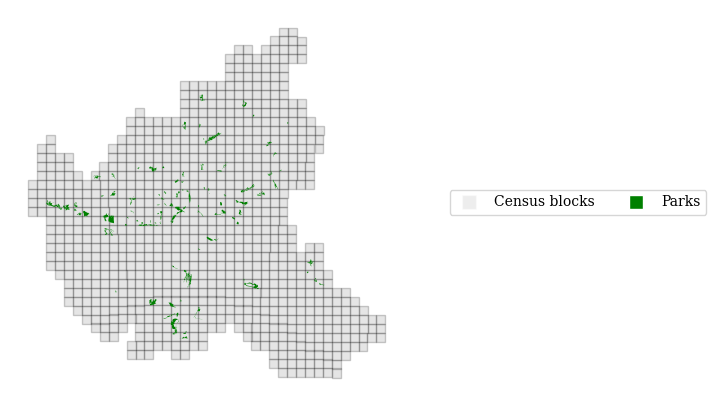

<Figure size 640x480 with 0 Axes>

In [14]:
fig,ax = plt.subplots(figsize = (8,5))
census_bbox.plot(ax=ax, facecolor = 'grey', edgecolor = 'black', alpha = 0.2, label = "Census Blocks")
park_areas.plot(ax=ax, facecolor = 'green', label = "Parks")
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgrey', alpha = 0.4, markersize=10, label='Census blocks'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Parks')
]
ax.set_axis_off()

ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor = (1.1,0.5), prop = FontProperties(family='serif', size = 10),ncol=3)

plt.show()
plt.savefig('census_parks_hamburg.png', bbox_inches='tight')

### Allgm. Gegenüberstellung 3 Ansätze

In [15]:
park_catchment_areas.head(1)

,name,geometry
0,Alsenpark,"POLYGON ((9.94989 53.56839, 9.94998 53.56841, ..."


In [16]:
# selecting geometrical data from different sources
park_name = "Berner Gutspark"
CA_entrance_park = park_catchment_areas[park_catchment_areas["name"] == park_name]["geometry"]
CA_centroid_park = park_centroid_catchment_areas[park_centroid_catchment_areas["name"] == park_name]["geometry"]
park_area = park_areas[park_areas["name"] == park_name]["geometry"]

#buffering from park area (including crs change for buffer method)
park_tmp = park_area.to_crs(epsg=3395)
park_tmp = park_tmp.centroid.buffer(700, cap_style = 1)
envgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(park_tmp))
buffer_park = gpd.GeoDataFrame(envgdf, crs='EPSG:3395')
buffer_park = buffer_park.to_crs(epsg=4326)


C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\1696079506.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park_area.centroid.plot(ax=ax[0],edgecolor = 'red', facecolor='red')
C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\1696079506.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park_area.centroid.plot(ax=ax[1],edgecolor = 'red', facecolor='red')


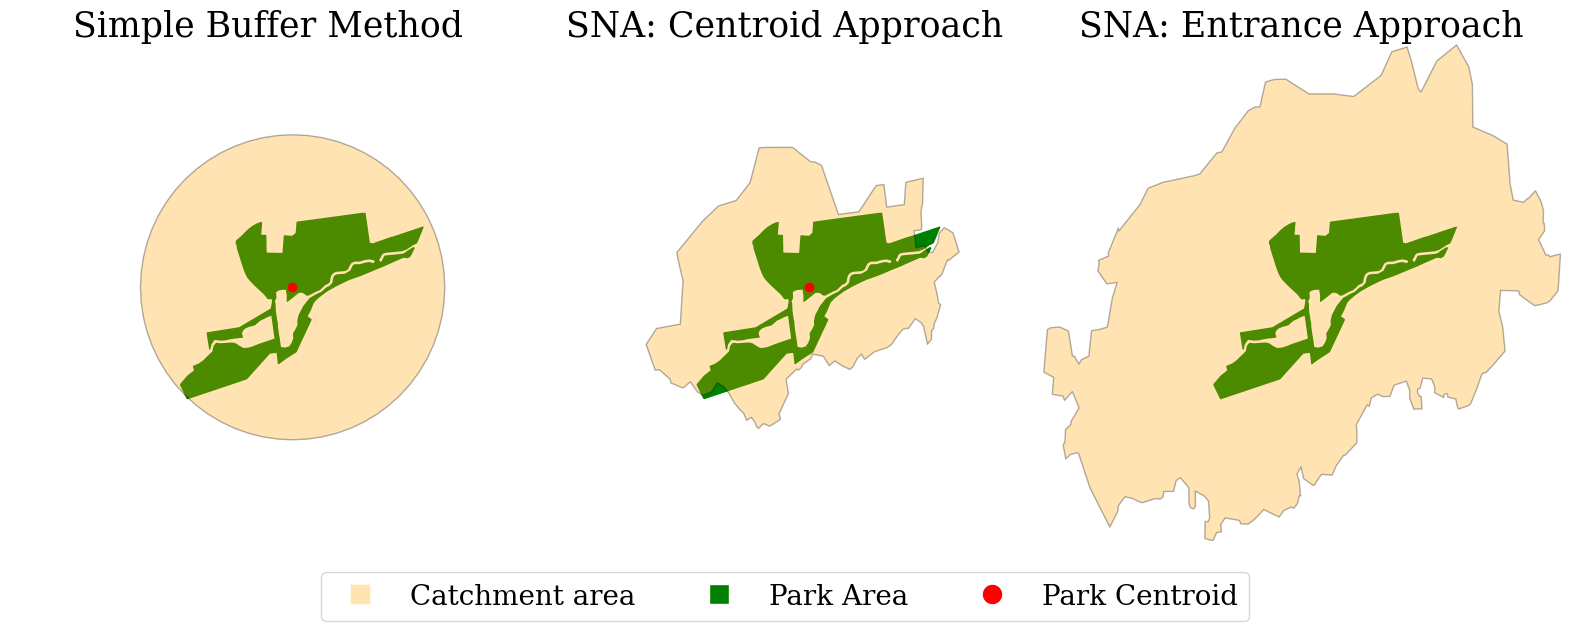

<Figure size 640x480 with 0 Axes>

In [17]:

# Subplots erstellen
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

# Plot für Buffer Park
park_area.plot(ax=ax[0], edgecolor='green', facecolor='green')
buffer_park.plot(ax=ax[0], edgecolor='black', facecolor='orange', alpha = 0.3)
park_area.centroid.plot(ax=ax[0],edgecolor = 'red', facecolor='red')
ax[0].set_title('Simple Buffer Method', fontsize = 25, fontfamily ='serif')

# Plot für CA Centroid Park
park_area.plot(ax=ax[1], edgecolor='green', facecolor='green')
CA_centroid_park.plot(ax=ax[1], edgecolor='black', facecolor='orange', alpha = 0.3)
park_area.centroid.plot(ax=ax[1],edgecolor = 'red', facecolor='red')
ax[1].set_title('SNA: Centroid Approach',fontsize = 25, fontfamily ='serif')

# Plot für CA Entrance Park
park_area.plot(ax=ax[2], edgecolor='green', facecolor='green')
CA_entrance_park.plot(ax=ax[2], edgecolor='black', facecolor='orange', alpha = 0.3)
ax[2].set_title('SNA: Entrance Approach',fontsize = 25, fontfamily ='serif')

# Achsenlimits setzen 
min_x = min(buffer_park.bounds.minx.min(), CA_centroid_park.bounds.minx.min(), CA_entrance_park.bounds.minx.min())
max_x = max(buffer_park.bounds.maxx.max(), CA_centroid_park.bounds.maxx.max(), CA_entrance_park.bounds.maxx.max())
min_y = min(buffer_park.bounds.miny.min(), CA_centroid_park.bounds.miny.min(), CA_entrance_park.bounds.miny.min())
max_y = max(buffer_park.bounds.maxy.max(), CA_centroid_park.bounds.maxy.max(), CA_entrance_park.bounds.maxy.max())

ax[0].set_xlim(min_x, max_x)
ax[0].set_ylim(min_y, max_y)
ax[1].set_xlim(min_x, max_x)
ax[1].set_ylim(min_y, max_y)
ax[2].set_xlim(min_x, max_x)
ax[2].set_ylim(min_y, max_y)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.subplots_adjust(wspace = 0.0)

# Legend configuration
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', alpha = 0.3, markersize=15, label='Catchment area'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=15, label='Park Area'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, label='Park Centroid')
]

fig.legend(handles=legend_elements, loc='lower center', prop = FontProperties(family='serif', size = 20),ncol=3)

plt.show()
plt.savefig('approach_overview_3types.png', bbox_inches='tight')

### Auswahl Parkformen

In [24]:
park_catchment_areas.head(1)

,name,geometry
0,Alsenpark,"POLYGON ((9.94989 53.56839, 9.94998 53.56841, ..."


In [26]:
# selecting geometrical data from different sources
park_name_1 = "Berner Gutspark"
park_name_2 = "Altonaer Balkon"
park_name_3 = "Waldpark Falkenstein"
park_area_1 = park_areas[park_areas["name"] == park_name_1]["geometry"]
park_area_2 = park_areas[park_areas["name"] == park_name_2]["geometry"]
park_area_3 = park_areas[park_areas["name"] == park_name_3]["geometry"]

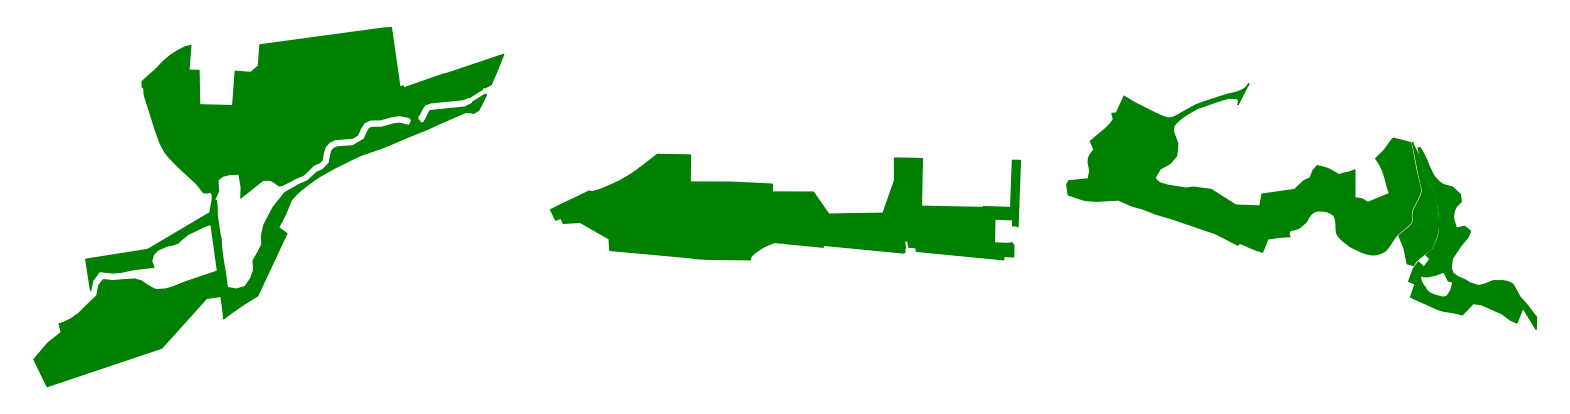

<Figure size 640x480 with 0 Axes>

In [30]:
# Subplots erstellen
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

# Plot für Buffer Park
park_area_1.plot(ax=ax[0], edgecolor='green', facecolor='green')
#ax[0].set_title('Simple Buffer Method', fontsize = 25, fontfamily ='serif')

# Plot für CA Centroid Park
park_area_2.plot(ax=ax[1], edgecolor='green', facecolor='green')
#ax[1].set_title('SNA: Centroid Approach',fontsize = 25, fontfamily ='serif')

# Plot für CA Entrance Park
park_area_3.plot(ax=ax[2], edgecolor='green', facecolor='green')
#ax[2].set_title('SNA: Entrance Approach',fontsize = 25, fontfamily ='serif')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.subplots_adjust(wspace = 0.0)

plt.show()
plt.savefig('park_shapes_overview.png', bbox_inches='tight')

### Census mit Beispiel Park und Soziodemografika

In [18]:
census_bbox.head(3)

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,row_number,geometry
0,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,census_box0,"POLYGON ((9.90980 53.41986, 9.90980 53.41085, ..."
1,3,-9.0,0.0,100.0,0.0,-1.0,-1.0,-9.0,-1.0,census_box1,"POLYGON ((10.16561 53.46473, 10.16561 53.45572..."
2,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,census_box2,"POLYGON ((9.92465 53.51871, 9.92465 53.50972, ..."


C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\4292290593.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, age, share_pop, share_sozio in zip(intersecting_blocks_centroid.geometry.centroid.x, intersecting_blocks_centroid.geometry.centroid.y, intersecting_blocks_centroid["Alter_D"], intersecting_blocks_centroid["share_overlap_pop"],intersecting_blocks_centroid["share_overlap_sozio"]):
C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\4292290593.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, age, share_pop, share_sozio in zip(intersecting_blocks_centroid.geometry.centroid.x, intersecting_blocks_centroid.geometry.centroid.y, intersecting_blocks_centroid["Alter_D"], intersecting_b

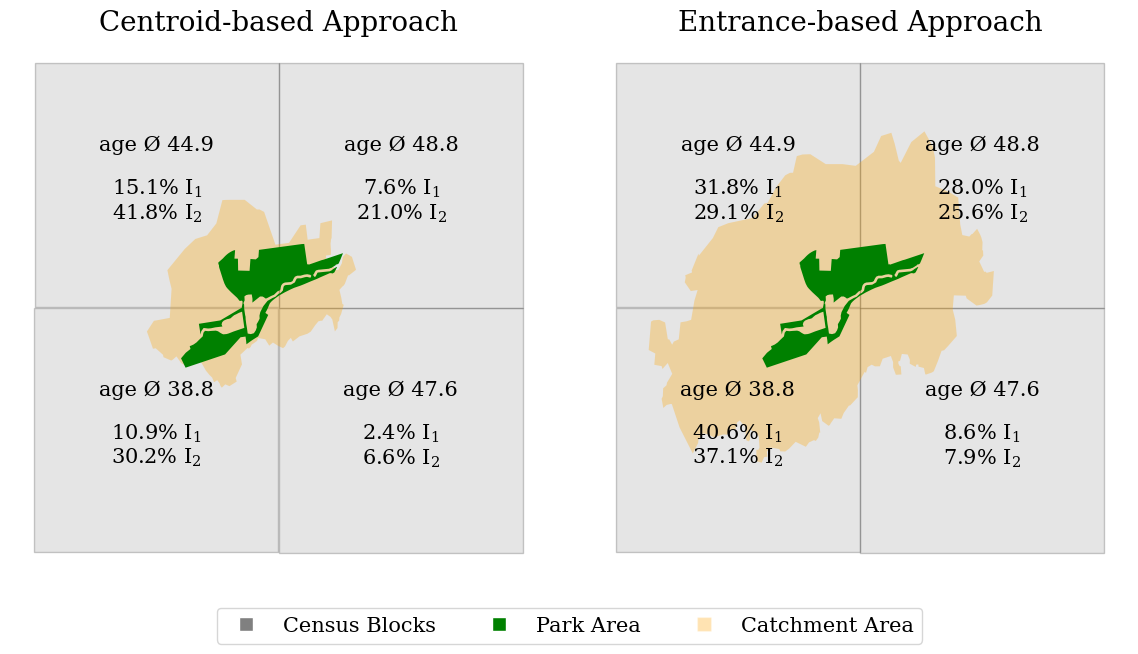

In [19]:
# buffering around park catchment area to get nearest census blocks
park_name = "Berner Gutspark"
park_area = park_areas[park_areas["name"] == park_name]["geometry"]
catchment_centroid_park_df = park_centroid_catchment_areas[park_centroid_catchment_areas["name"] == park_name ].reset_index()
catchment_entrance_park_df = park_catchment_areas[park_catchment_areas["name"] == park_name].reset_index()

# find subset of census blocks intersecting using exisiting files
intersecting_blocks_centroid = centroid_intersection[centroid_intersection["name"] == park_name].round({"Alter_D":1, "share_overlap_pop": 1,  "share_overlap_sozio": 1})
intersecting_blocks_entrance = entrance_intersection[entrance_intersection["name"] == park_name].round({"Alter_D":1, "share_overlap_pop": 1,  "share_overlap_sozio": 1})

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
font_size = 15

# Plotting Centroid Approach Data
intersecting_blocks_centroid.plot(ax=ax[0], facecolor = 'grey', edgecolor = 'black', alpha = 0.2, label = 'Census Blocks')
catchment_centroid_park_df.plot(ax=ax[0],facecolor = 'orange',alpha = 0.3, label = 'Catchment Area')
park_area.plot(ax=ax[0], facecolor = 'green', label = "Park")
ax[0].set_title('Centroid-based Approach',fontsize = 20, fontfamily ='serif')

for x, y, age, share_pop, share_sozio in zip(intersecting_blocks_centroid.geometry.centroid.x, intersecting_blocks_centroid.geometry.centroid.y, intersecting_blocks_centroid["Alter_D"], intersecting_blocks_centroid["share_overlap_pop"],intersecting_blocks_centroid["share_overlap_sozio"]):
    ax[0].text(x, y+0.0015, "age Ø "+str(age),font =FontProperties(family='serif', size = font_size), ha='center', va='center')
    ax[0].text(x, y-0.00009, str(share_pop) + "% "+ "$\mathregular{I_1}$", font =FontProperties(family='serif', size = font_size), ha='center', va='center')
    ax[0].text(x, y-0.001, str(share_sozio) + "% "+ "$\mathregular{I_2}$", font =FontProperties(family='serif', size = font_size), ha='center', va='center')

# Plotting Entrance Approach Data
intersecting_blocks_entrance.plot(ax=ax[1], facecolor = 'grey', edgecolor = 'black', alpha = 0.2, label = 'Census Blocks')
catchment_entrance_park_df.plot(ax=ax[1],facecolor = 'orange',alpha = 0.3, label = 'Catchment Area')
park_area.plot(ax=ax[1], facecolor = 'green', label = "Park")
ax[1].set_title('Entrance-based Approach',fontsize = 20, fontfamily ='serif')

for x, y, age, share_pop, share_sozio in zip(intersecting_blocks_entrance.geometry.centroid.x, intersecting_blocks_entrance.geometry.centroid.y, intersecting_blocks_entrance["Alter_D"], intersecting_blocks_entrance["share_overlap_pop"],intersecting_blocks_entrance["share_overlap_sozio"]):
    ax[1].text(x, y+0.0015, "age Ø "+str(age),font =FontProperties(family='serif', size = font_size), ha='center', va='center')
    ax[1].text(x, y-0.00009, str(share_pop) + "% "+ "$\mathregular{I_1}$", font =FontProperties(family='serif', size = font_size), ha='center', va='center')
    ax[1].text(x, y-0.001, str(share_sozio) + "% "+ "$\mathregular{I_2}$", font =FontProperties(family='serif', size = font_size), ha='center', va='center')


# Legend configurations
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='grey',  markersize=10, label='Census Blocks'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Park Area'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', alpha = 0.3 ,markersize=10, label='Catchment Area')
]

fig.legend(handles=legend_elements, loc='lower center', prop = FontProperties(family='serif', size = 15),ncol=3)
ax[0].set_axis_off()
ax[1].set_axis_off()

plt.subplots_adjust(wspace = -0.4)
plt.savefig('census_catchment_calculation.png', bbox_inches='tight')

In [20]:
entrance_intersection
test = entrance_intersection[entrance_intersection["name"] == park_name]
test

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,row_number,name,share_overlap_pop,share_overlap_sozio,geometry
74,5693,38.80,21.66,16.02,13.30,2.16,0.80,32.9,70.0,census_box224,Berner Gutspark,40.624324,37.132244,"POLYGON ((10.13599 53.62649, 10.13599 53.61752..."
75,1472,44.90,17.80,23.10,3.06,2.45,0.97,39.0,-9.0,census_box629,Berner Gutspark,31.815512,29.074420,"POLYGON ((10.13602 53.63548, 10.13602 53.62651..."
76,5004,47.58,12.89,28.80,7.39,1.89,1.68,44.0,79.0,census_box755,Berner Gutspark,8.642575,7.899660,"POLYGON ((10.15110 53.62648, 10.15110 53.61750..."
77,4137,48.84,12.69,31.40,5.51,1.88,0.70,42.4,77.0,census_box800,Berner Gutspark,28.033192,25.617979,"POLYGON ((10.15113 53.63546, 10.15113 53.62649..."


### Detaillierter Vergleich 2 Ansätze

In [21]:
entrances_df = pd.read_json('../get_park_data/total_park_entrances.json')
park_name_ = "Berner Gutspark"
park_area_ = park_areas[park_areas["name"] == park_name_]["geometry"]
entrances = entrances_df[entrances_df["name"]== park_name_]

geometry = [Point(xy) for xy in zip(entrances['long'], entrances['lat'])]
entrance_points = gpd.GeoDataFrame(entrances, geometry=geometry, crs="EPSG:4326")


C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\1444062663.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park_area_.centroid.plot(ax=ax[0],edgecolor = 'red', facecolor='red')


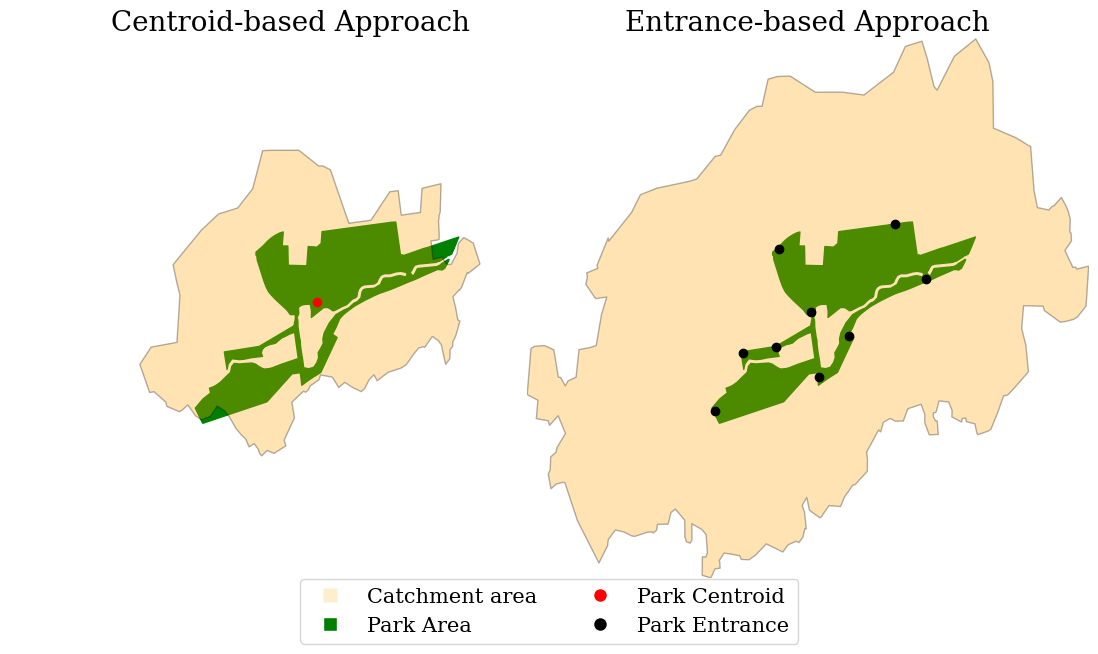

<Figure size 640x480 with 0 Axes>

In [22]:
# Subplots erstellen
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot für CA Centroid Park
park_area_.plot(ax=ax[0], edgecolor='green', facecolor='green')
CA_centroid_park.plot(ax=ax[0], edgecolor='black', facecolor='orange', alpha = 0.3)
park_area_.centroid.plot(ax=ax[0],edgecolor = 'red', facecolor='red')
ax[0].set_title('Centroid-based Approach',fontsize = 20, fontfamily ='serif')

# Plot für CA Entrance Park
park_area_.plot(ax=ax[1], edgecolor='green', facecolor='green')
CA_entrance_park.plot(ax=ax[1], edgecolor='black', facecolor='orange', alpha = 0.3)
entrance_points.plot(ax=ax[1],edgecolor = 'black', facecolor='black')
ax[1].set_title('Entrance-based Approach',fontsize = 20, fontfamily ='serif')

# Achsenlimits setzen 
min_x = min(CA_centroid_park.bounds.minx.min(), CA_entrance_park.bounds.minx.min())
max_x = max(CA_centroid_park.bounds.maxx.max(), CA_entrance_park.bounds.maxx.max())
min_y = min(CA_centroid_park.bounds.miny.min(), CA_entrance_park.bounds.miny.min())
max_y = max(CA_centroid_park.bounds.maxy.max(), CA_entrance_park.bounds.maxy.max())

ax[0].set_xlim(min_x, max_x)
ax[0].set_ylim(min_y, max_y)
ax[1].set_xlim(min_x, max_x)
ax[1].set_ylim(min_y, max_y)


ax[0].set_axis_off()
ax[1].set_axis_off()
plt.subplots_adjust(wspace = -0.5)

# Legend configuration
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', alpha = 0.2, markersize=10, label='Catchment area'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Park Area'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Park Centroid'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Park Entrance')
]

fig.legend(handles=legend_elements, loc='lower center', prop = FontProperties(family='serif', size = 15),ncol=2)

plt.show()
plt.savefig('approach_overview_2types.png')

### Vergleich Census Resolution Problematik

C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\4021060822.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, age in zip(intersecting_blocks_centroid.geometry.centroid.x, intersecting_blocks_centroid.geometry.centroid.y, intersecting_blocks_centroid["Alter_D"]):
C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\4021060822.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, age in zip(intersecting_blocks_centroid.geometry.centroid.x, intersecting_blocks_centroid.geometry.centroid.y, intersecting_blocks_centroid["Alter_D"]):
C:\Users\nico-\AppData\Local\Temp\ipykernel_35620\4021060822.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 

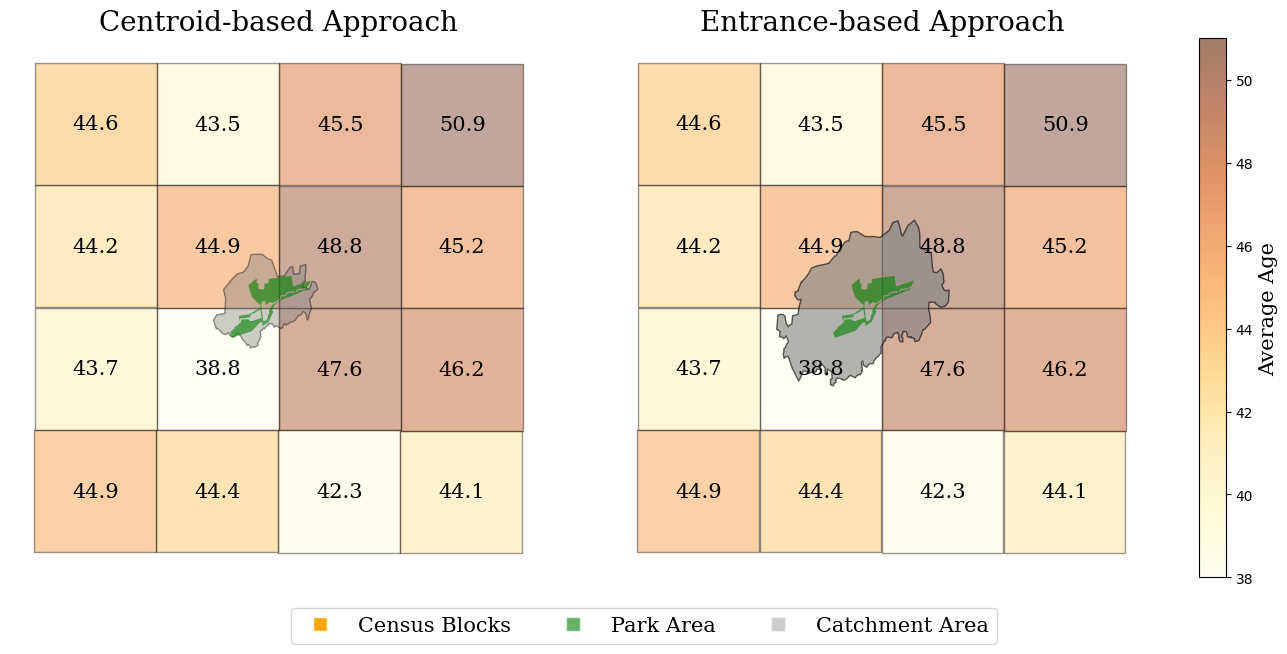

In [23]:
# buffering around park catchment area to get nearest census blocks
park_name = "Berner Gutspark"
park_area = park_areas[park_areas["name"] == park_name]["geometry"]
catchment_centroid_park_df = park_centroid_catchment_areas[park_centroid_catchment_areas["name"] == park_name ].reset_index()
catchment_entrance_park_df = park_catchment_areas[park_catchment_areas["name"] == park_name].reset_index()

buffer =2100
# buffering arround park catchment area to get nearest census blocks - centroid approach
park_3395_c = catchment_centroid_park_df.to_crs(epsg=3395)
bbox_park_centroid = park_3395_c.buffer(buffer,cap_style = 1)

# convert buffered polygon back to 4326 crs
envgdf_c = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_park_centroid))
bbox_4326_centroid = gpd.GeoDataFrame(envgdf_c, crs='EPSG:3395')
bbox_4326_centroid = bbox_4326_centroid.to_crs(epsg=4326)
bbox_4326_centroid["name"] = catchment_centroid_park_df["name"]

# find subset of census blocks intersecting with buffered catchment area
intersecting_blocks_centroid = gpd.sjoin(census_bbox,bbox_4326_centroid,how = "inner", predicate="intersects")

# buffering arround park catchment area to get nearest census blocks - entrance approach
park_3395_e = catchment_entrance_park_df.to_crs(epsg=3395)
bbox_park_entrance = park_3395_e.buffer(buffer,cap_style = 1)

# convert buffered polygon back to 4326 crs
envgdf_e = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_park_entrance))
bbox_4326_entrance = gpd.GeoDataFrame(envgdf_e, crs='EPSG:3395')
bbox_4326_entrance = bbox_4326_centroid.to_crs(epsg=4326)
bbox_4326_entrance["name"] = catchment_entrance_park_df["name"]

# find subset of census blocks intersecting with buffered catchment area
intersecting_blocks_centroid = gpd.sjoin(census_bbox,bbox_4326_centroid,how = "inner", predicate="intersects").round({"Alter_D":1})
intersecting_blocks_entrance = gpd.sjoin(census_bbox,bbox_4326_entrance,how = "inner", predicate="intersects").round({"Alter_D":1})

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
font_size = 15

# Plotting Centroid Approach Data
intersecting_blocks_centroid.plot(ax=ax[0], cmap='YlOrBr', facecolor = 'grey', edgecolor = 'black', alpha = 0.4, label = 'Census Blocks')
catchment_centroid_park_df.plot(ax=ax[0],facecolor = 'grey',alpha = 0.4, edgecolor = 'black', label = 'Catchment Area')
park_area.plot(ax=ax[0], facecolor = 'green',alpha = 0.6, label = "Park")
ax[0].set_title('Centroid-based Approach',fontsize = 20, fontfamily ='serif')

for x, y, age in zip(intersecting_blocks_centroid.geometry.centroid.x, intersecting_blocks_centroid.geometry.centroid.y, intersecting_blocks_centroid["Alter_D"]):
    ax[0].text(x, y, str(age),font =FontProperties(family='serif', size = font_size), ha='center', va='center')


# Plotting Entrance Approach Data
intersecting_blocks_entrance.plot(ax=ax[1],cmap='YlOrBr', facecolor = 'grey', edgecolor = 'black', alpha = 0.4, label = 'Census Blocks')
catchment_entrance_park_df.plot(ax=ax[1],facecolor = 'grey',alpha = 0.6,edgecolor = 'black', label = 'Catchment Area')
park_area.plot(ax=ax[1], facecolor = 'green',alpha = 0.6, label = "Park")
ax[1].set_title('Entrance-based Approach',fontsize = 20, fontfamily ='serif')

for x, y, age in zip(intersecting_blocks_entrance.geometry.centroid.x, intersecting_blocks_entrance.geometry.centroid.y, intersecting_blocks_entrance["Alter_D"]):
    ax[1].text(x, y, str(age),font =FontProperties(family='serif', size = font_size), ha='center', va='center')


# colorbar for age variable
vmin, vmax = 38, 51
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, alpha = 0.6)
cbar.set_label(label = 'Average Age',family = 'serif',size = 15)



# Legend configurations
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor= 'orange',  markersize=10, label='Census Blocks'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', alpha = 0.6, markersize=10, label='Park Area'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='grey', alpha = 0.4 ,markersize=10, label='Catchment Area')
]

fig.legend(handles=legend_elements, loc='lower center', prop = FontProperties(family='serif', size = 15),ncol=3)
ax[0].set_axis_off()
ax[1].set_axis_off()

plt.subplots_adjust(wspace = -0.4)
plt.savefig('census_resolution_problem.png', bbox_inches='tight')